In [1]:
from graphix.transpiler import Circuit, Statevec
from graphix.pattern import Pattern
from graphix.ops import Ops
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from scipy.optimize import minimize
from functools import reduce
import seaborn as sns
from matplotlib import cm
from IPython.display import clear_output
from time import time

np.random.seed(0)

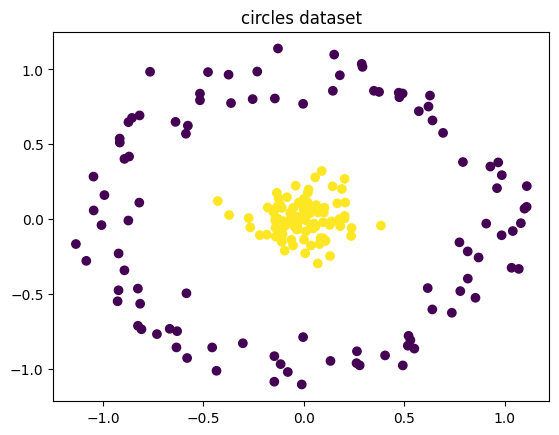

In [2]:
# Generate a dataset with a circle pattern
x, y = make_circles(n_samples=200, noise=0.1, factor=0.1, random_state=32)

# Plot the circle pattern
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title('circles dataset')
plt.show()

In [3]:
# pad data
x = np.pad(x, ((0, 0), (0, 1)))

# hinge labels
y = 2*y - 1
x.shape, y.shape

((200, 3), (200,))

In [2]:
class QNN:
    def __init__(self, n_qubits, n_layers, n_features):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_features = n_features
        assert n_features % 3 == 0, "n_features must be a multiple of 3"
        
        Z = np.array([[1, 0], 
                      [0, -1]])

        operator = [Z]*self.n_qubits
        self.obs = reduce(np.kron, operator)
        self.cost_values = []
        
    def rotation_layer(self, circuit, qubit, params, input_params):
        z = params[:, 0]*input_params + params[:, 1]
        circuit.rx(qubit, z[0])
        circuit.ry(qubit, z[1])
        circuit.rz(qubit, z[2])

    def entangling_layer(self, circuit, n_qubits):
        if n_qubits < 2:
            return 
        
        # Linear entanglement
        for i in range(n_qubits - 1):
            circuit.cnot(i, i + 1)

    def data_reuploading_circuit(self, input_params, params):
        thetas = params.reshape(self.n_layers, self.n_qubits, self.n_features, 2)
        circuit = Circuit(self.n_qubits)
        for l in range(self.n_layers):
            for f in range(self.n_features//3):
                for q in range(self.n_qubits):
                    self.rotation_layer(circuit, q, thetas[l][q][3*f:3*(f+1)], input_params[3*f:3*(f+1)])

            # Entangling layer
            if l < self.n_layers -1:
                self.entangling_layer(circuit, self.n_qubits)

        return circuit
    
    def get_expectation_value(self,sv):
        exp_val = self.obs@sv
        exp_val = np.dot(sv.conj(), exp_val)
        return exp_val.real
    
    def compute_expectation(self, data_point, params):
        circuit = self.data_reuploading_circuit(data_point, params)
        pattern = circuit.transpile()
        pattern.standardize()
        pattern.shift_signals()
        pattern.perform_pauli_measurements()
        out_state = pattern.simulate_pattern('tensornetwork')
        sv = out_state.to_statevector().flatten()
        return self.get_expectation_value(sv)
    
    def cost(self, params, x, y):
        y_pred = [self.compute_expectation(data_point, params) for data_point in x] 
        cost_val = np.mean(np.abs(y - y_pred))
        self.cost_values.append(cost_val)
        return cost_val
    
    def callback(self, xk):
        clear_output(wait=True)
        plt.ylabel('Cost')
        plt.xlabel('Iterations')
        plt.plot(self.cost_values, color='purple', lw=2, label=f'Cost {np.round(self.cost_values[-1],2)}')
        plt.legend()
        plt.grid()
        plt.show()

    def fit(self, x, y):
        params = np.random.rand(self.n_layers*self.n_qubits*self.n_features*2)
        res = minimize(self.cost, 
                       params, 
                       args=(x, y), 
                       method='COBYLA', 
                       callback=self.callback, 
                       options = {'maxiter': 100, 'disp':True})
        return res

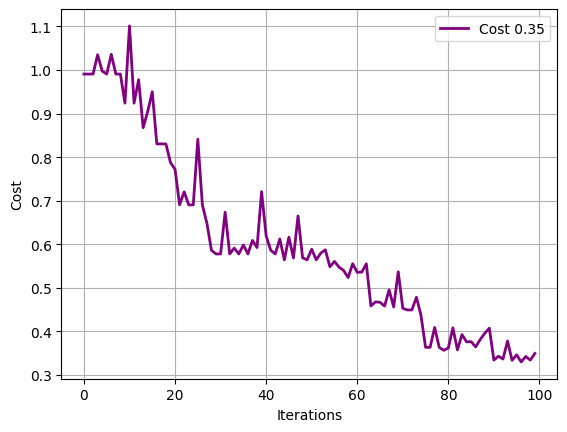

Duration: 935.3211953639984


In [12]:
n_qubits = 2
n_layers = 2
n_features = 3

qnn = QNN(n_qubits, n_layers, n_features)

start = time()
result = qnn.fit(x, y)
end = time()

print("Duration:", end-start)

In [13]:
result

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.3298752851673516
       x: [ 3.262e-02  6.170e-02 ... -2.182e-01  1.647e-01]
    nfev: 100
   maxcv: 0.0

In [14]:
predictions = np.array([qnn.compute_expectation(data_point, result.x) for data_point in x])
predictions[predictions > 0.0] = 1.0
predictions[predictions <= 0.0] = -1.0

In [15]:
np.mean(y == predictions)

0.995

In [16]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 1.5
GRID_Y_START = -1.5
GRID_Y_END = 1.5
# output directory

grid = np.mgrid[GRID_X_START:GRID_X_END:20j,GRID_X_START:GRID_Y_END:20j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [18]:
grid_2d = np.pad(grid_2d, ((0, 0), (0, 1)))
predictions = np.array([qnn.compute_expectation(data_point, result.x) for data_point in grid_2d])

In [19]:
predictions.shape, XX.shape

((400,), (20, 20))

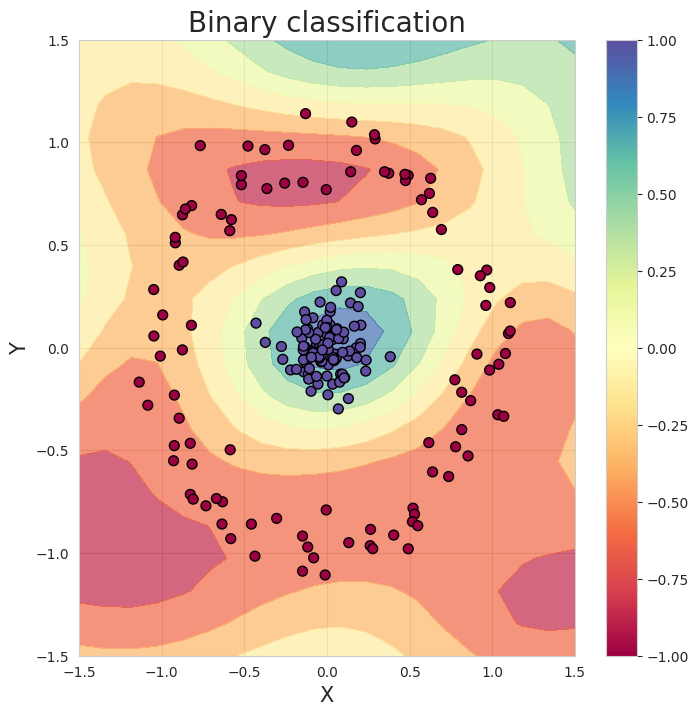

In [20]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
plt.title('Binary classification', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.contourf(XX, YY, predictions.reshape(XX.shape), alpha = 0.7, cmap=cm.Spectral)
plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), s=50, cmap=plt.cm.Spectral, edgecolors='black')
plt.colorbar()
plt.show()

In [40]:
n_qubits = 2
n_layers = 2
n_features = 3

params = np.random.rand(n_layers * n_qubits * n_features * 2)
input_params = np.random.rand(n_features)

qnn = QNN(n_qubits, n_layers, n_features)
circuit = qnn.data_reuploading_circuit(input_params, params)
pattern = circuit.transpile()
pattern.standardize()
pattern.shift_signals()

print(pattern.max_space())

36


In [41]:
nodes, edges = pattern.get_graph()
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

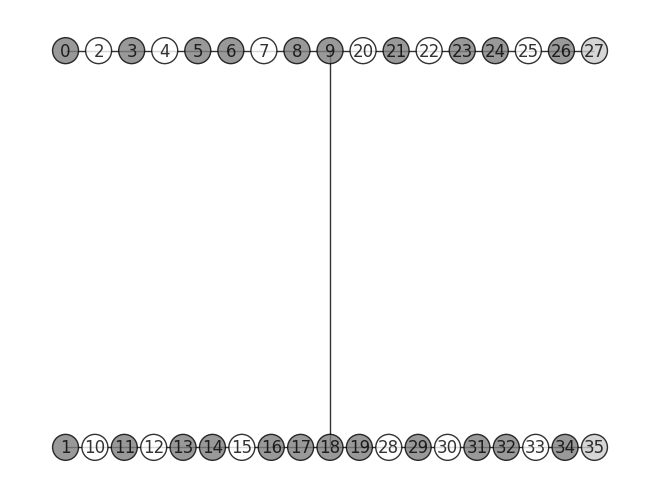

In [42]:
from graphix.gflow import flow

f, l_k = flow(g, set(range(n_qubits)), set(pattern.output_nodes))

flow = [[i] for i in range(n_qubits)]
for i in range(n_qubits):
    contd = True
    val = i
    while contd:
        try:
            val = f[val]
            flow[i].append(val)
        except KeyError:
            contd = False
longest = np.max([len(flow[i]) for i in range(n_qubits)])

pos = dict()
for i in range(n_qubits):
    length = len(flow[i])
    fac = longest / (length - 1)
    for j in range(len(flow[i])):
        pos[flow[i][j]] = (fac * j, -i)

# determine wheher or not a node will be measured in Pauli basis
def get_clr_list(pattern):
    nodes, edges = pattern.get_graph()
    meas_list = pattern.get_measurement_commands()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    clr_list = []
    for i in g.nodes:
        for cmd in meas_list:
            if cmd[1] == i:
                if cmd[3] in [-1, -0.5, 0, 0.5, 1]:
                    clr_list.append([0.5, 0.5, 0.5])
                else:
                    clr_list.append([1, 1, 1])
        if i in pattern.output_nodes:
            clr_list.append([0.8, 0.8, 0.8])
    return clr_list

graph_params = {"with_labels": True, 
                "alpha":0.8, 
                "node_size": 350, 
                "node_color": get_clr_list(pattern), 
                "edgecolors": "k"}

nx.draw(g, pos=pos, **graph_params)

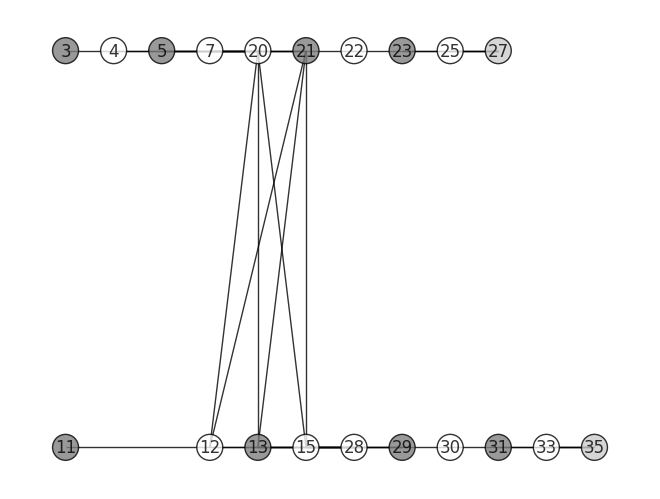

In [44]:
pattern.perform_pauli_measurements()
nodes, edges = pattern.get_graph()
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
graph_params = {"with_labels": True, 
                "alpha":0.8, 
                "node_size": 350, 
                "node_color": get_clr_list(pattern), 
                "edgecolors": "k"}

pos = { # hand-typed for better look
    3: (0,0),
    4: (1,0),
    5: (2,0),
    7: (3,0),
    11: (0,-1),
    12: (3,-1),
    13: (4,-1),
    15: (5,-1),
    20: (4,0),
    21: (5,0),
    22: (6,0),
    23: (7,0),
    25: (8,0),
    27: (9,0),
    28: (6,-1),
    29: (7,-1),
    30: (8,-1),
    31: (9,-1),
    33: (10,-1),
    35: (11,-1),
}

nx.draw(g, pos=pos, **graph_params)

In [45]:
out_state = pattern.simulate_pattern('tensornetwork')
state = circuit.simulate_statevector()
print("overlap of states: ", np.abs(np.dot(state.psi.flatten().conjugate(), 
                                           out_state.to_statevector().flatten())))

overlap of states:  0.9999999999999999


In [3]:
qubits = range(1, 16, 2)
n_layers = 2
n_features = 3
input_params = np.random.rand(n_features)

before_meas = []
after_meas = []



for n_qubits in qubits:
    print("n_qubits:", n_qubits)
    
    params = np.random.rand(n_layers * n_qubits * n_features * 2)
    qnn = QNN(n_qubits, n_layers, n_features)
    circuit = qnn.data_reuploading_circuit(input_params, params)
    pattern = circuit.transpile()
    pattern.standardize()
    pattern.shift_signals()

    before_meas.append(pattern.max_space())
    
    pattern.perform_pauli_measurements()
    after_meas.append(pattern.max_space())
    
    del circuit, pattern, qnn, params

n_qubits: 1
n_qubits: 3
n_qubits: 5
n_qubits: 7
n_qubits: 9
n_qubits: 11
n_qubits: 13
n_qubits: 15


Text(0, 0.5, 'max space')

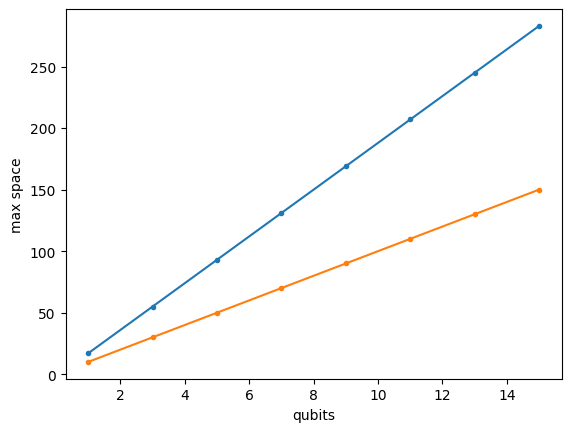

In [12]:
plt.plot(qubits, before_meas, '.-', label='Before Pauli Meas')
plt.plot(qubits, after_meas, '.-', label='After Pauli Meas')
plt.xlabel("qubits")
plt.ylabel("max space")